# Exercise 1
____

Bellow, you'll find the code that was used to generate the activity of place cells on a linear track. Use the code and the decoding procedure you learned to explore how different features of the data impact our ability to decode position. 

<font color='teal'> **Q1.1** - Try to use different fractions of the data samples. How does the median error change when the number of available samples gets larger? </font>

<font color='teal'> **Q1.2** - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10, 20, 30,... cells. How does the median error change? </font>

<font color='teal'> **Q1.3** - Generate new data changing the firing rate noise. How does this impact decoding? </font>
_____

**ANS.:**

See bellow

In [2]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

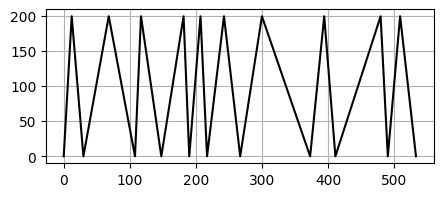

In [5]:
# Generate trajectory
n_runs = 10 
use_stops = False
fps = 10
track_length = 200
bins = np.arange(0, track_length)

running_speed_a = np.random.chisquare(10, n_runs)
running_speed_b = np.random.chisquare(10, n_runs)

stopping_time_a = np.random.chisquare(15, n_runs)
stopping_time_b = np.random.chisquare(15, n_runs)

x = np.array([])

for i in range(n_runs):
    
    stop1 = np.zeros( int(stopping_time_a[i] * fps) )
    run_length = int( len(bins) * fps / running_speed_a[i] )
    run1 = np.linspace(0, float(len(bins) - 1), run_length)
    
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins) - 1.)
    run_length = int( len(bins) * fps / running_speed_b[i] )
    run2 = np.linspace(len(bins) - 1, 0, run_length)
    
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))

t = np.arange(len(x)) / fps

plt.figure(figsize=(5,2))
plt.plot(t, x, 'k')
plt.grid()

In [6]:
average_firing_rate = 5   # Peak firing rate, averaged across the population 
n_cells = 100 

pf_centers = np.random.rand(n_cells) * track_length                          # Place field centers
pf_size = np.random.gamma(10, size=n_cells)                                  # Place field widths 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells)     # Peak firing rate for each cell

true_firing_rate_maps = np.zeros((n_cells, len(bins)))

for i in range(n_cells):
    # Gaussian spread firing rate
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp( -(( bins - pf_centers[i])**2 ) / ( 2*pf_size[i]**2 ))

<font color='teal'> **Q1.1** - Try to use different fractions of the data samples. How does the median error change when the number of available samples gets larger? </font>

To explore the effect of using a different number of samples on the median error, we change the former by changing the `sampling_rate` (10, 100, 1000). What we observe is that the median usually starts in the highest value, quickly decreases to $\approx 3.6$ and oscillates around that value as the sampling rate increases.

This means that after some point, no matter how many samples we collect , we are not necessarily increasing the accuracy of the prediction, rather it plateaus. This feels intuitive given that increasing the sampling rate means only that we increase the number of samples collected each second so the temporal resolution is still the same. After some number of samples, we are effectively just collecting redundant data hence the convergence of the median error.

In [ ]:
# How many samples we collect each second
sampling_rate = 100

t_sampling = np.arange(0, t[-1], 1 / sampling_rate)

# Given our sampling rate, what actual x's do we record
x_sampling = np.floor(np.interp(t_sampling, t, x)) 
print(len(x_sampling))
noise_firing_rate = 0.1 
spike_times = []
bins = np.arange(0, track_length)

for i in range(n_cells):

    inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate / sampling_rate)
    sp = np.argwhere(spikes_loc) # Find indices of non-zero elements
    t_sp = t_sampling[sp]
    spike_times.append(t_sp)

# Extract the spike counts for each neuron
spike_counts = np.asarray([np.histogram(s,t)[0] for s in spike_times])
spike_counts = spike_counts.T

In [ ]:
def bayes_decoding(x, t, firing_rate_map, spike_counts, fps, bins):

    x, t = x[:-1], t[:-1]
    decoded_location = np.zeros(len(x))

    for t_bin in tqdm(range(len(t))):

        # Check if the time bin has spikes
        if sum(spike_counts[t_bin,:]) > 0:
            posterior = np.empty(firing_rate_map.shape[-1])

            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spike_counts[t_bin,:], firing_rate_map[:,i] / fps), pow(1, -15))
                
            decoded_location[t_bin] = bins[np.argmax(posterior)]
        
        else:
            decoded_location[t_bin] = np.nan

    return decoded_location

def faster_bayes_decoding(firing_rate_map, spike_counts, fps, bins):
    epsilon = pow(1, -10)
    log_posteriors = spike_counts @ np.log(firing_rate_map + epsilon) - (1/fps) * np.sum(firing_rate_map, axis = 0)
    decoded_locations = [bins[np.argmax(P)] for P in log_posteriors]
    return decoded_locations

s1 = time.time()
decoded_locations = bayes_decoding(x,t, true_firing_rate_maps, spike_counts, fps,bins)
e1 = time.time()

s2 = time.time()
faster_decoded_locations = faster_bayes_decoding(true_firing_rate_maps, spike_counts, fps,bins)
e2 = time.time()

print('First one took {} and second took {}'.format(np.round(e1-s1, 3), np.round(e2-s2,3)))

In [ ]:
# Plot the resulting, prediction/decoding
plt.figure(figsize=(6,3))
plt.plot(decoded_locations, '.', color='indianred', label='Decoded')
plt.plot(x[:-1], 'k', label='Ground truth')
plt.grid()
plt.legend(shadow=True)
plt.show()

# Error distribution
mse = np.sqrt((x[:-1] - decoded_locations)**2)
plt.figure(figsize=(6,3))
plt.hist(mse, bins=300, color='teal', alpha=0.75)
plt.axvline(x = np.nanmedian(mse), c='k', label = 'Median = {}'.format(np.round(np.nanmedian(mse), 2)))
plt.legend(shadow=True)
plt.grid()
plt.xlim([0,50])
plt.title('Error distribution')

In [ ]:
sr = np.arange(10, 500, 10)
medians = np.zeros(len(sr))

for s, sampling_rate in enumerate(sr):
   
    t_sampling = np.arange(0, t[-1], 1 / sampling_rate)   
    x_sampling = np.floor(np.interp(t_sampling, t, x)) 
    noise_firing_rate = 0.1 
    spike_times = []
    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc) 
        t_sp = t_sampling[sp]
        spike_times.append(t_sp)
    spike_counts = np.asarray([np.histogram(s,t)[0] for s in spike_times])
    spike_counts = spike_counts.T

    decoded_locations = faster_bayes_decoding(true_firing_rate_maps, spike_counts, fps, bins)
    mse = np.sqrt((x[:-1] - decoded_locations)**2)
    medians[s] =  np.nanmedian(mse)

In [ ]:
plt.plot(sr, medians,'.-k')
plt.grid()
plt.xlabel('Sampling rate')
plt.ylabel('Median')

med = np.mean(medians[10:])
plt.axhline(med, linestyle= '--' ,color = 'indianred', label='Avg median (excluding init points)')
plt.legend(shadow=True)
plt.show()

<font color='teal'> **Q1.2** - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10, 20, 30,... cells. How does the median error change? </font>


With increasing number of cells the median of the error decreases. We that the curve approaches the same value as in the previous exercise though it a stabler fashion as it doesn't oscillate as much. The difference from the previous exercise is that further increasing th enumber of cells seems to decreases the median even more but much slower. 

As such, increasing the number of cells being recorded does improve the accuracy of the prediction but at some point, in a real experiment, we would have to stop as the accuracy we would get wouldn't compensate for the cost of recording more cells.

In [9]:
def fr_map(n_cells, bins, avg_firing_rate = 5, track_length = 200):
    
    pf_centers = np.random.rand(n_cells) * track_length                          # Place field centers
    pf_size = np.random.gamma(10, size=n_cells)                                  # Place field widths 
    pf_rate = np.random.exponential(scale=avg_firing_rate, size=n_cells)     # Peak firing rate for each cell

    fr_maps = np.zeros((n_cells, len(bins)))

    for i in range(n_cells):
        # Gaussian spread firing rate
        fr_maps[i,:] = pf_rate[i] * np.exp( -(( bins - pf_centers[i])**2 ) / ( 2*pf_size[i]**2 ))

    return fr_maps

In [ ]:
number_of_cells = np.arange(10, 1001, 25) 
medians = np.zeros(len(number_of_cells))
fps = 10
track_length = 200
bins = np.arange(0, track_length)
sampling_rate = 100

for n, n_cells in enumerate(number_of_cells):
   
    t_sampling = np.arange(0, t[-1], 1 / sampling_rate)   
    x_sampling = np.floor(np.interp(t_sampling, t, x)) 
    noise_firing_rate = 0.1 
    spike_times = []

    true_firing_rate_maps = fr_map(n_cells, bins)

    for i in range(n_cells):

        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc) 
        t_sp = t_sampling[sp]
        spike_times.append(t_sp)

    spike_counts = np.asarray([np.histogram(s,t)[0] for s in spike_times])
    spike_counts = spike_counts.T

    decoded_locations = faster_bayes_decoding(true_firing_rate_maps, spike_counts, fps, bins)
    mse = np.sqrt((x[:-1] - decoded_locations)**2)
    medians[n] =  np.nanmedian(mse)

In [ ]:
plt.plot(number_of_cells, medians,'.-k')
plt.grid()
plt.xlabel('# Cells')
plt.ylabel('Median')

plt.axhline(med, linestyle= '--' ,color = 'indianred', label='Avg median - ex.(1.1)')
plt.legend(shadow=True)
plt.show()

<font color='teal'> **Q1.3** - Generate new data changing the firing rate noise. How does this impact decoding? </font>

Clearly,it worsens it!

In [ ]:
noises = np.arange(0.01, 5, 0.05) 
medians = np.zeros(len(noises))
fps = 10
track_length = 200
bins = np.arange(0, track_length)
sampling_rate, n_cells = 100, 100

for n, noise_firing_rate in enumerate(noises):
   
    t_sampling = np.arange(0, t[-1], 1 / sampling_rate)   
    x_sampling = np.floor(np.interp(t_sampling, t, x)) 
    spike_times = []

    true_firing_rate_maps = fr_map(n_cells, bins)

    for i in range(n_cells):

        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc) 
        t_sp = t_sampling[sp]
        spike_times.append(t_sp)

    spike_counts = np.asarray([np.histogram(s,t)[0] for s in spike_times])
    spike_counts = spike_counts.T

    decoded_locations = faster_bayes_decoding(true_firing_rate_maps, spike_counts, fps, bins)
    mse = np.sqrt((x[:-1] - decoded_locations)**2)
    medians[n] =  np.nanmedian(mse)

In [ ]:
plt.plot(noises, medians,'.-k')
plt.grid()
plt.xlabel('Firing rate noise')
plt.ylabel('Median')

# Exercise 2
____

In the loop implementation of the decoder, we used the `poison.logpmf(k, mu)` to calculate the log probability of observing $k$ spikes given an average firing rate $\mu$. This is mathematically equivalent to `np.log(poisson.pmf(k,  mu))`, in which we calculate the probability first and then take th elog.

Re-run the decoding with 

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

Do you observe any differences in the results? What do you think this is due to?
_____

**ANS.:**

Though they ultimately yielçd the same result, they arrive at it differently. The `poisson.logpmf()` computes the natural logarithm of the probability mass function of the Poisson distribution directly whereas `np.log(poinsson.pmf())` first calculates the pmf and then takes the natural logarithm

The difference between using `poisson.logpmf()` or `np.log(poinsson.pmf())` is evident. The latter is a more unstable or more susceptible to data flutuations than the former. This can be seen by the fact that many locations are predicted as zero. The efficiency of `poisson.logpmf()` arises from the fact that it does not go through the intermediate steps of calculating the two functions separately.

In [ ]:
def bayes_decoding_ex2(x, t, firing_rate_map, spike_counts, fps, bins):

    x, t = x[:-1], t[:-1]
    decoded_location = np.zeros(len(x))

    for t_bin in tqdm(range(len(t))):

        # Check if the time bin has spikes
        if sum(spike_counts[t_bin,:]) > 0:
            posterior = np.empty(firing_rate_map.shape[-1])

            for i in range(len(posterior)):
                posterior[i] = sum(np.log(poisson.pmf(spike_counts[t_bin,:],firing_rate_map[:,i]/fps)+pow(1,-15)))
                
            decoded_location[t_bin] = bins[np.argmax(posterior)]
        
        else:
            decoded_location[t_bin] = np.nan

    
    return decoded_location

decoded_locations1 = bayes_decoding(x, t, true_firing_rate_maps, spike_counts, fps, bins)
decoded_locations2 = bayes_decoding_ex2(x, t, true_firing_rate_maps, spike_counts, fps, bins)

In [ ]:
mse1 = np.nanmedian(np.sqrt((x[:-1] - decoded_locations1)**2))
mse2 = np.nanmedian(np.sqrt((x[:-1] - decoded_locations2)**2))

# Plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(decoded_locations1, '.', color='indianred', label='Median of error = {}'.format(np.round(mse1,2)))
plt.plot(x[:-1], 'k')
plt.legend(shadow=True, loc='upper right')
plt.title('poisson.logpmf()')
plt.grid()

plt.subplot(1,2,2)
plt.plot(decoded_locations2, '.', color='teal', label='Median of error = {}'.format(np.round(mse2, 2)))
plt.title('np.log(poisson.pmf())')
plt.plot(x[:-1], 'k')
plt.legend(shadow=True, loc='upper right')
plt.grid()

# Exercise 3
____

<font color='teal'> **Q1.1** - Estimate the quality of the sequence detection methods we saw in the lesson. How many false positives/negatives does it find? </font>

<font color='teal'> **Q1.2** -  Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive/negative rates of the detection procedure.</font>

<font color='teal'> **Q1.3** -  What kinf of sequence can our methods detect? What kind of activity, despite being sequential, could escape our detection method? Do you have any idea of a different method for sequence detection? </font>
_____

**ANS.:**

See bellow

<font color='teal'> **Q1.1** - Estimate the quality of the sequence detection methods we saw in the lesson. How many false positives/negatives does it find? </font>

Suppose we generated 200 events half of which are sequences and the other half random activity. The measure we use to distinguish between the two is that the slope of the predicted locations. The slope is zero for random activity and non-zero for actuall sequences.

In one run of the code in the notebook I found the following:

<img src='exercise_3_histograms.png'>

Setting a threshold of $\pm 1$ for the random activity

```
inds_less = np.where(reactivation_slopes < -1)[0] 
inds_more = np.where(reactivation_slopes > 1)[0]
```

I found that out of the 200 events, 186 were predicted as sequences. That is, the number of false positives is much bigger than the number of false negatives. So the quality of the method isn't bery good. This could be caused by the fact that such a small number of cells can still yield some linear structure.

<font color='teal'> **Q1.2** -  Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive/negative rates of the detection procedure.</font>

It doesn't seem to have any effect. I removed the noise completely (setting it to zero) and the performance remains pretty much the same. **WHY??**

<font color='teal'> **Q1.3** -  What kind of sequence can our methods detect? What kind of activity, despite being sequential, could escape our detection method? Do you have any idea of a different method for sequence detection? </font>

Oscillatory firing of the neurons